In [51]:

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:
# Standard Library Imports
import warnings

import pandas as pd
import shap

# Custom Module Imports
from Prep import DiabetesDataset
from Train_model import TrainAutoGluon
from Vis import (
    plot_feature_distributions,
    generate_categorical_summary_table,
    plot_correlation_heatmap,
    subgroup_analysis_with_plot,
    shap_summary_plot,
    plot_feature_importance,
    compare_predictors_with_calibration
)

# Suppress warnings and set pandas options
pd.set_option("future.no_silent_downcasting", True)
warnings.filterwarnings('ignore')

# Fetch dataset from UCI repository
from ucimlrepo import fetch_ucirepo

# Load dataset with different preprocessing requirements
# orginal_data = DiabetesDataset(fetch_ucirepo(id=296)).data_preprocessing(drop_first=False, remove_duplicates=False,remove_all_high_missing=False)
processed_data = DiabetesDataset(fetch_ucirepo(id=296)).data_preprocessing(remove_duplicates=True,
                                                                           remove_all_high_missing=False)

Removed columns with high missing values: 'weight', 'payer_code'
Total rows before filtering: 101766
Total rows after filtering: 71518
Removing constant columns: ['examide', 'citoglipton', 'glimepiride-pioglitazone']


# 1.Exploratory Data Analysis (EDA)

## 1.1 Data Visualization for key numerical features

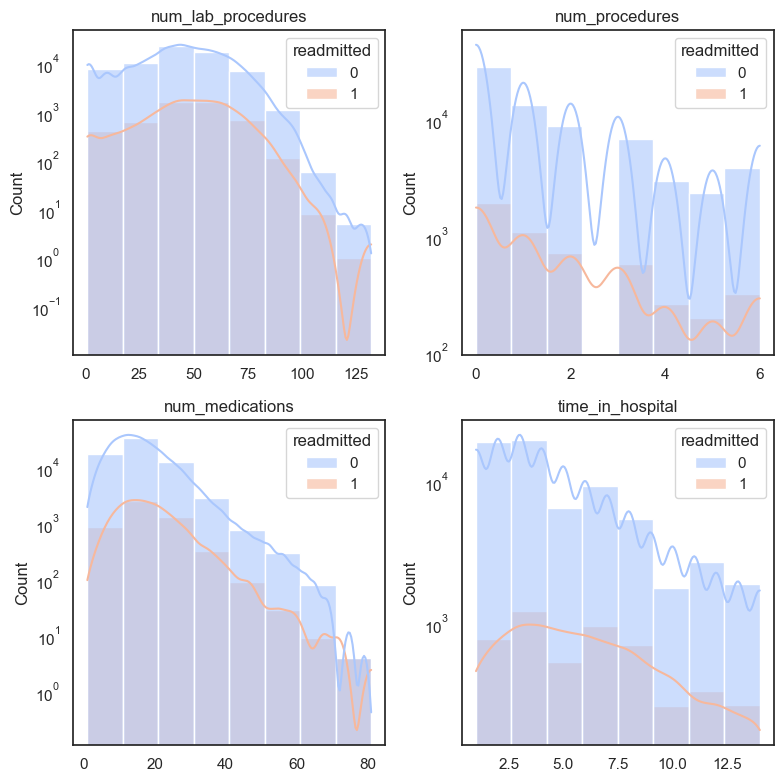

Plotting complete!


In [53]:
numerical_cols = ['num_lab_procedures', 'num_procedures', 'num_medications', 'time_in_hospital']

plot_feature_distributions(processed_data, numerical_columns=numerical_cols, numerical_plot_type="histogram",
                           target_col='readmitted')

## 1.2 Patient demographics and admission/discharge characteristics table 

In [54]:
# Define categorical prefixes
categorical_prefixes = ['medical_specialty_grouped', "race_grouped",
                        "admission_type_id", "admission_source_id", "discharge_disposition_id",
                        "diag_1", 'age'
                        ]

# Generate the summary table
table_2 = generate_categorical_summary_table(processed_data, categorical_prefixes, target_column="readmitted")
table_2

,Variable,"Overall, n (%)","Readmitted = 0, n (%)","Readmitted = 1, n (%)"
0,gender,38024 (53.2%),35372 (53.2%),2652 (52.4%)
1,medical_specialty_grouped_Emergency Medicine,4450 (6.2%),4188 (6.3%),262 (5.2%)
2,medical_specialty_grouped_Internal Medicine,16052 (22.4%),14789 (22.3%),1263 (24.9%)
3,medical_specialty_grouped_Nephrology,866 (1.2%),790 (1.2%),76 (1.5%)
4,medical_specialty_grouped_Obstetrics & Gynecology,683 (1.0%),668 (1.0%),15 (0.3%)
5,medical_specialty_grouped_Orthopedics,2105 (2.9%),1991 (3.0%),114 (2.3%)
6,medical_specialty_grouped_Other,37122 (51.9%),34437 (51.8%),2685 (53.0%)
7,medical_specialty_grouped_Psychiatry & Psychology,720 (1.0%),663 (1.0%),57 (1.1%)
8,medical_specialty_grouped_Pulmonology,664 (0.9%),604 (0.9%),60 (1.2%)
9,medical_specialty_grouped_Radiology,852 (1.2%),808 (1.2%),44 (0.9%)


## 1.3 Correlation heatmap

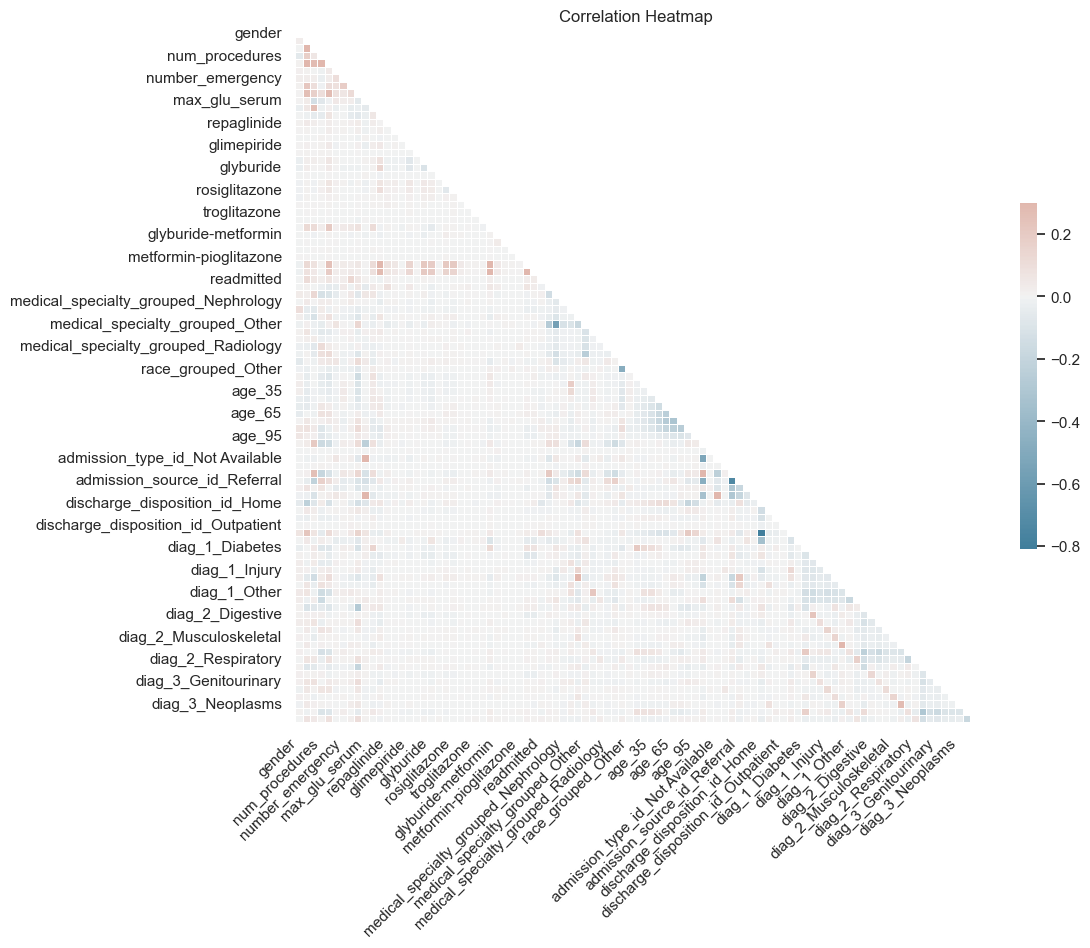

In [55]:
plot_correlation_heatmap(processed_data.drop(columns=["encounter_id", "patient_nbr"]), figsize=(11, 9), square=False)

# 2. Model Training

## 2.1 Model Training with/without clustered features

### 2.1.1 Model Training without clustered features

In [70]:
# Initialize the AutoGluon trainer
trainer_wo_cluster = TrainAutoGluon(processed_data)
# Run the full pipeline
#trainer_wo_cluster.run_pipeline()
trainer_wo_cluster.run_pipeline(cluster='No cluster', num_features=0, eval_metric='roc_auc',
                                sample_weight='auto_weight', verbosity=0, time_limit=1000)

Data split complete.
Running ML pipeline...
Removed 1 low-variance features.


No path specified. Models will be saved in: "AutogluonModels\ag-20250404_161210"


Removed 0 highly correlated features.
Normalization complete.
Skipping feature selection step...
Skipping imbalanced data step...
Skipping clustering step...
Sample weight: auto_weight
Label distribution:
readmitted
0    53160
1     4052
Name: count, dtype: int64


AssertionError: Not enough time left to train models for the full fit. Consider specifying a larger time_limit or setting `dynamic_stacking=False`. Time remaining: -381.24s

In [13]:
trainer_wo_cluster.model_eval()

,model_type,model,score_test
0,WeightedEnsemble_L2,WeightedEnsemble_L2,0.699079
1,LightGBM,LightGBM\T1,0.699043
2,CatBoost,CatBoost\T1,0.697703
3,LinearModel,LinearModel\T2,0.691565
4,RandomForest,RandomForest\T3,0.690625
5,ExtraTrees,ExtraTrees\T4,0.686726
6,NeuralNetTorch,NeuralNetTorch\4d4ca852,0.681488
7,TabPFNMix,TabPFNMix,0.640554
8,XGBoost,XGBoost\T1,0.627407


### 2.1.2 Model Training with clustered features

In [14]:
# Initialize the AutoGluon trainer
trainer_w_cluster = TrainAutoGluon(processed_data)
# Run the full pipeline
trainer_w_cluster.run_pipeline(cluster="As features", num_features=0)

ML Pipeline Completed.


In [15]:
trainer_w_cluster.model_eval()

,model_type,model,score_test
0,WeightedEnsemble_L2,WeightedEnsemble_L2,0.698677
1,LightGBM,LightGBM\T2,0.696549
2,CatBoost,CatBoost\T3,0.696185
3,LinearModel,LinearModel\T1,0.691112
4,RandomForest,RandomForest\T4,0.687589
5,NeuralNetTorch,NeuralNetTorch\85310187,0.684562
6,ExtraTrees,ExtraTrees\T4,0.681707
7,TabPFNMix,TabPFNMix,0.638184
8,XGBoost,XGBoost\T3,0.623165


## 2.2 Model Training with Top 10 features

In [16]:
# Initialize the AutoGluon trainer
trainer_w_top_10 = TrainAutoGluon(processed_data)
# Run the full pipeline
trainer_w_top_10.run_pipeline(cluster="No cluster", num_features=10)

ML Pipeline Completed.


In [17]:
trainer_w_top_10.model_eval()

,model_type,model,score_test
0,CatBoost,CatBoost\T3,0.668270
1,WeightedEnsemble_L2,WeightedEnsemble_L2,0.667244
2,ExtraTrees,ExtraTrees\T3,0.665979
3,LightGBM,LightGBM\T2,0.664931
4,RandomForest,RandomForest\T3,0.661769
5,LinearModel,LinearModel\T4,0.661390
6,NeuralNetTorch,NeuralNetTorch\f9100058,0.660523
7,TabPFNMix,TabPFNMix,0.644370
8,XGBoost,XGBoost\T4,0.592523


## 2.3 Model Training with different data imbalancing techniques

### 2.3.1 Model Training with SMOTE

In [18]:
# Initialize the AutoGluon trainer
trainer_wo_cluster_smote = TrainAutoGluon(processed_data)
# Run the full pipeline
trainer_wo_cluster_smote.run_pipeline(cluster="No cluster", num_features=0, imbalanced='smote')

ML Pipeline Completed.


In [19]:
trainer_wo_cluster_smote.model_eval()

,model_type,model,score_test
0,LightGBM,LightGBM\T3,0.657122
1,WeightedEnsemble_L2,WeightedEnsemble_L2,0.637394
2,CatBoost,CatBoost\T1,0.636796
3,RandomForest,RandomForest\T1,0.633391
4,XGBoost,XGBoost\T4,0.620684
5,NeuralNetTorch,NeuralNetTorch\9e453d93,0.611887
6,ExtraTrees,ExtraTrees\T2,0.595378
7,TabPFNMix,TabPFNMix,0.588902
8,LinearModel,LinearModel\T2,0.581972


### 2.3.2 Model Training with down sampling

In [ ]:
# Initialize the AutoGluon trainer
trainer_wo_cluster_undersample = TrainAutoGluon(processed_data)
# Run the full pipeline
trainer_wo_cluster_undersample.run_pipeline(cluster="No cluster", num_features=0, imbalanced='undersample')


In [32]:
trainer_wo_cluster_undersample.model_eval()

,model_type,model,score_test
0,WeightedEnsemble_L2,WeightedEnsemble_L2,0.694577
1,LightGBM,LightGBM\T2,0.691055
2,CatBoost,CatBoost\T5,0.690010
3,RandomForest,RandomForest\T3,0.688010
4,LinearModel,LinearModel\T1,0.684914
5,TabPFNMix,TabPFNMix,0.681936
6,ExtraTrees,ExtraTrees\T3,0.678305
7,NeuralNetTorch,NeuralNetTorch\8632d2ba,0.672479
8,XGBoost,XGBoost\T4,0.658293


### 2.3.3 Model Training with down sampling ADASYN

In [21]:
# Initialize the AutoGluon trainer
trainer_wo_cluster_adasyn = TrainAutoGluon(processed_data)
# Run the full pipeline
trainer_wo_cluster_adasyn.run_pipeline(cluster="No cluster", num_features=0, verbosity=0, imbalanced='adasyn')

ML Pipeline Completed.


In [22]:
trainer_wo_cluster_adasyn.model_eval()

,model_type,model,score_test
0,LightGBM,LightGBM\T4,0.657980
1,CatBoost,CatBoost\T1,0.636999
2,WeightedEnsemble_L2,WeightedEnsemble_L2,0.633109
3,RandomForest,RandomForest\T1,0.632738
4,NeuralNetTorch,NeuralNetTorch\ca74bdfb,0.628153
5,XGBoost,XGBoost\T4,0.624292
6,ExtraTrees,ExtraTrees\T1,0.595214
7,TabPFNMix,TabPFNMix,0.581530
8,LinearModel,LinearModel\T1,0.581223


## 2.7 Calibration of the models

In [69]:
all_predictors = {
    # "No Clustering": trainer_wo_cluster,
    "With Clustering": trainer_w_cluster,
    "Top 10 Features": trainer_w_top_10,
    "Down sample": trainer_wo_cluster_undersample,
    "SMOTE": trainer_wo_cluster_smote,
    "ADASYN": trainer_wo_cluster_adasyn,
}

results_df = compare_predictors_with_calibration(all_predictors, metric="f1")
display(results_df)


,Model,Calibrated,Accuracy,Precision,Recall,F1,AUROC
0,With Clustering,False,0.797525,0.155759,0.420533,0.227321,0.698677
1,With Clustering,True,0.797525,0.155759,0.420533,0.227321,0.698677
2,Top 10 Features,False,0.826610,0.150215,0.310958,0.202572,0.667244
3,Top 10 Features,True,0.826610,0.150215,0.310958,0.202572,0.667244
4,Down sample,False,0.764944,0.144199,0.469891,0.220677,0.694577
5,Down sample,True,0.764944,0.144199,0.469891,0.220677,0.694577
6,SMOTE,False,0.632105,0.105332,0.559724,0.177298,0.637394
7,SMOTE,True,0.632105,0.105332,0.559724,0.177298,0.637394
8,ADASYN,False,0.617982,0.103368,0.572557,0.175121,0.633109
9,ADASYN,True,0.617982,0.103368,0.572557,0.175121,0.633109


## 2.6 Performance visualization

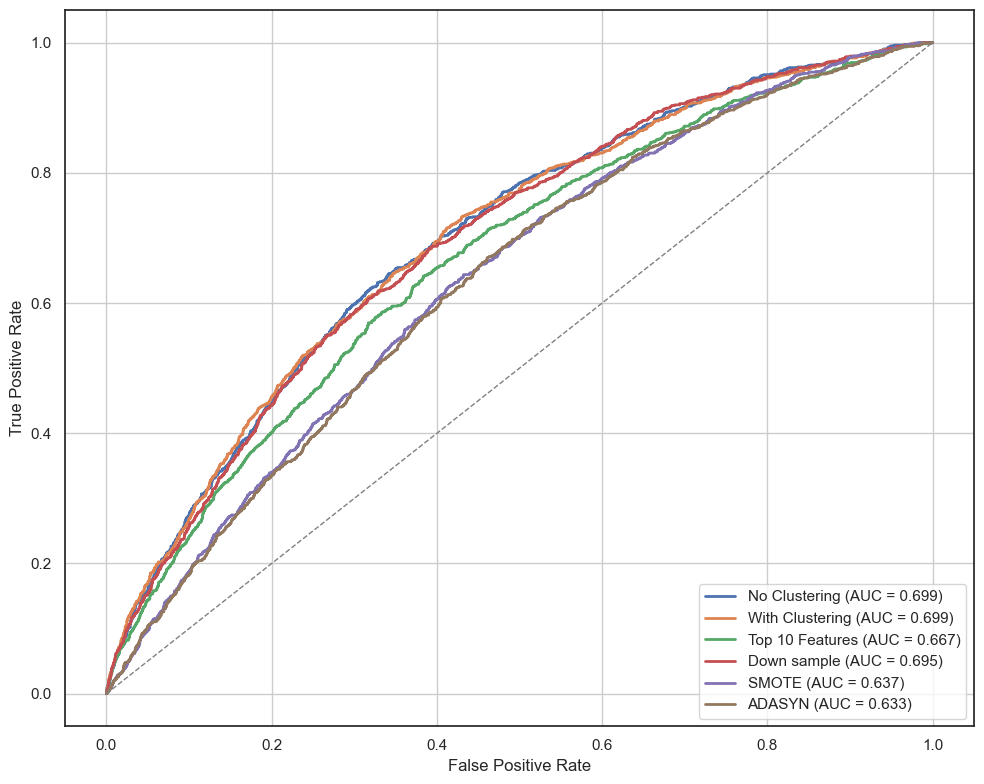

In [58]:
from Vis import plot_combined_roc_curves

# Example usage:
plot_combined_roc_curves(all_predictors, label_col="readmitted")

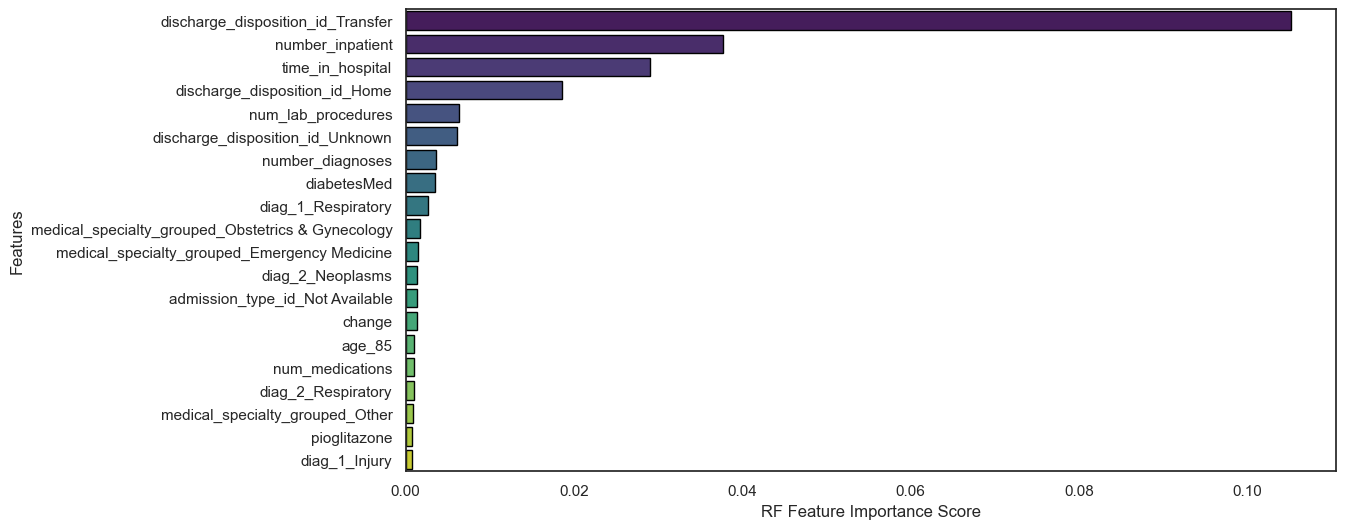

In [25]:
plot_feature_importance(trainer_wo_cluster, top_n=20)

In [ ]:
import matplotlib.pyplot as plt

shap_values, X_test_sample = shap_summary_plot(trainer_wo_cluster, target_class=1, nsamples=50)

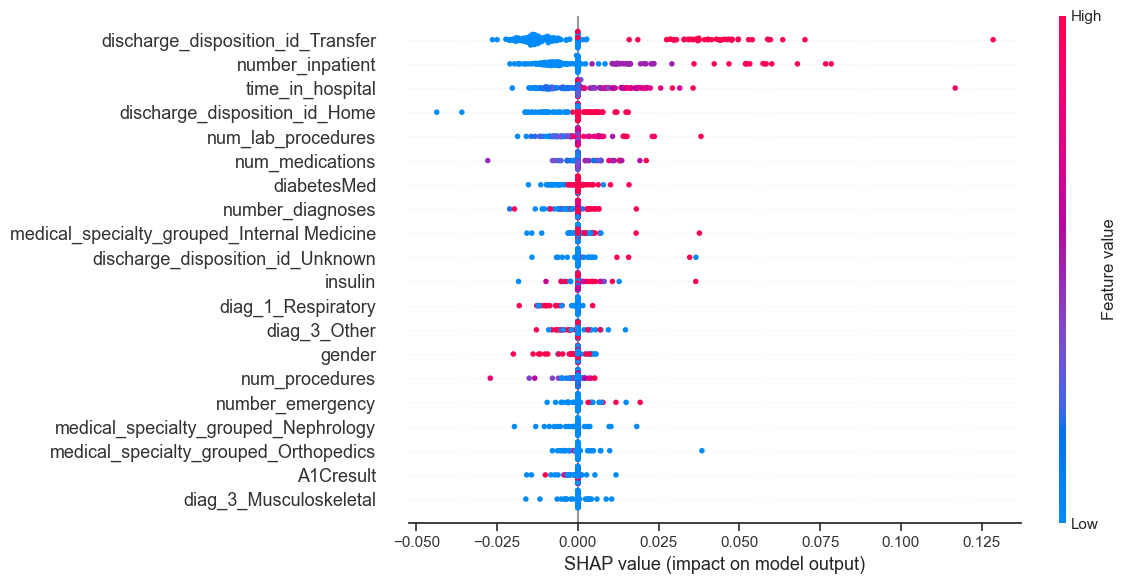

In [27]:
shap.summary_plot(shap_values, X_test_sample, show=False, plot_size=[12, 6])
plt.tight_layout()
plt.show()

# 3. Subgroup Analysis

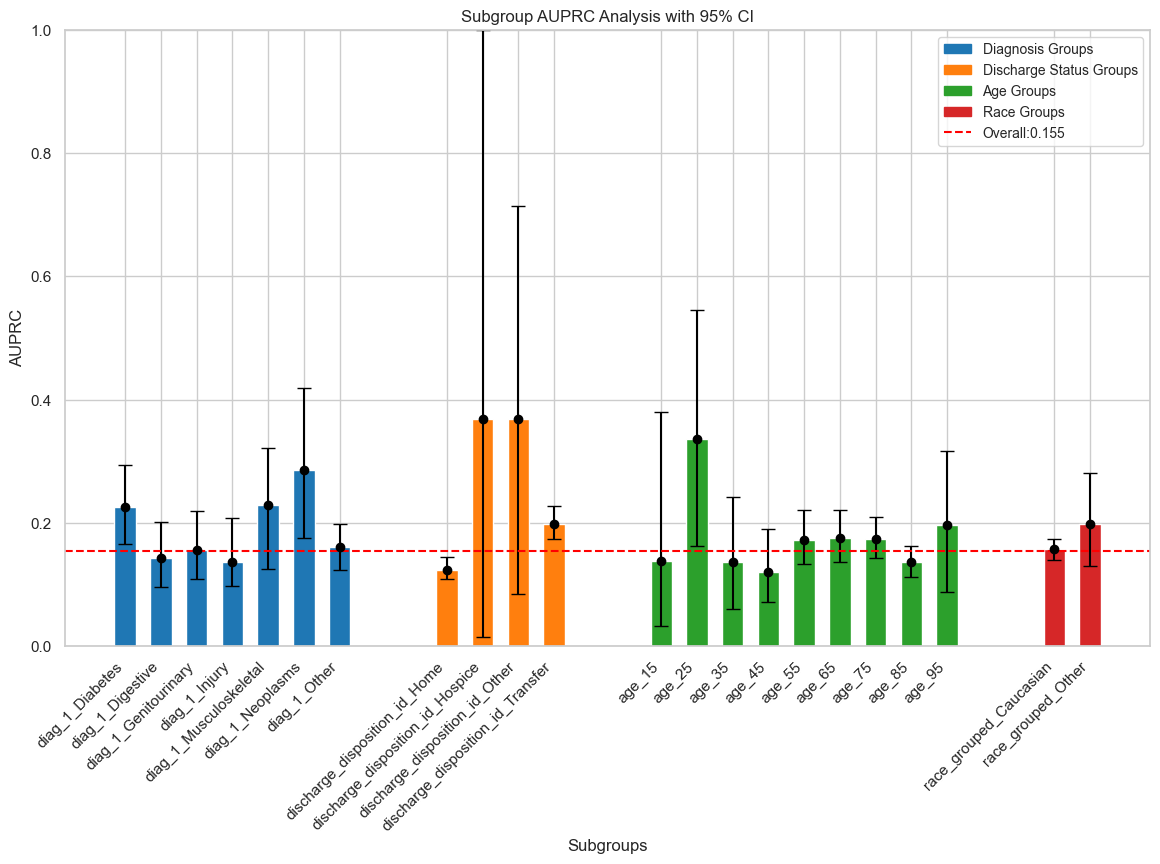

,Group,Subgroup,Metric,95% CI Lower,95% CI Upper,Sample Size
0,Diagnosis Groups,diag_1_Diabetes,0.226,0.166,0.294,1149
1,Diagnosis Groups,diag_1_Digestive,0.143,0.095,0.201,1392
2,Diagnosis Groups,diag_1_Genitourinary,0.156,0.108,0.219,689
3,Diagnosis Groups,diag_1_Injury,0.137,0.097,0.208,990
4,Diagnosis Groups,diag_1_Musculoskeletal,0.228,0.125,0.322,779
5,Diagnosis Groups,diag_1_Neoplasms,0.285,0.175,0.418,559
6,Diagnosis Groups,diag_1_Other,0.160,0.124,0.198,2541
7,Discharge Status Groups,discharge_disposition_id_Home,0.124,0.108,0.145,10334
8,Discharge Status Groups,discharge_disposition_id_Hospice,0.368,0.014,1.000,110
9,Discharge Status Groups,discharge_disposition_id_Other,0.369,0.084,0.714,64


In [29]:
subgroup_columns = [
    'diag_1_Diabetes', 'diag_1_Digestive', 'diag_1_Genitourinary',
    'diag_1_Injury', 'diag_1_Musculoskeletal', 'diag_1_Neoplasms', 'diag_1_Other'
]

discharge_subgroup = [
    'discharge_disposition_id_Home', 'discharge_disposition_id_Hospice',
    'discharge_disposition_id_Other', 'discharge_disposition_id_Outpatient',
    'discharge_disposition_id_Transfer'
]

age_subgroup = ['age_15', 'age_25', 'age_35', 'age_45', 'age_55', 'age_65', 'age_75', 'age_85', 'age_95', ]

race_subgroup = ['race_grouped_Caucasian', 'race_grouped_Other']

# Define group sets (Dictionary of subgroups)
group_sets = {
    "Diagnosis Groups": subgroup_columns,
    "Discharge Status Groups": discharge_subgroup,
    "Age Groups": age_subgroup,
    "Race Groups": race_subgroup
}

# Run analysis & generate bar plot
subgroup_analysis_with_plot(trainer_wo_cluster, group_sets, metric='auprc', n_bootstrap=100, confidence=0.95)

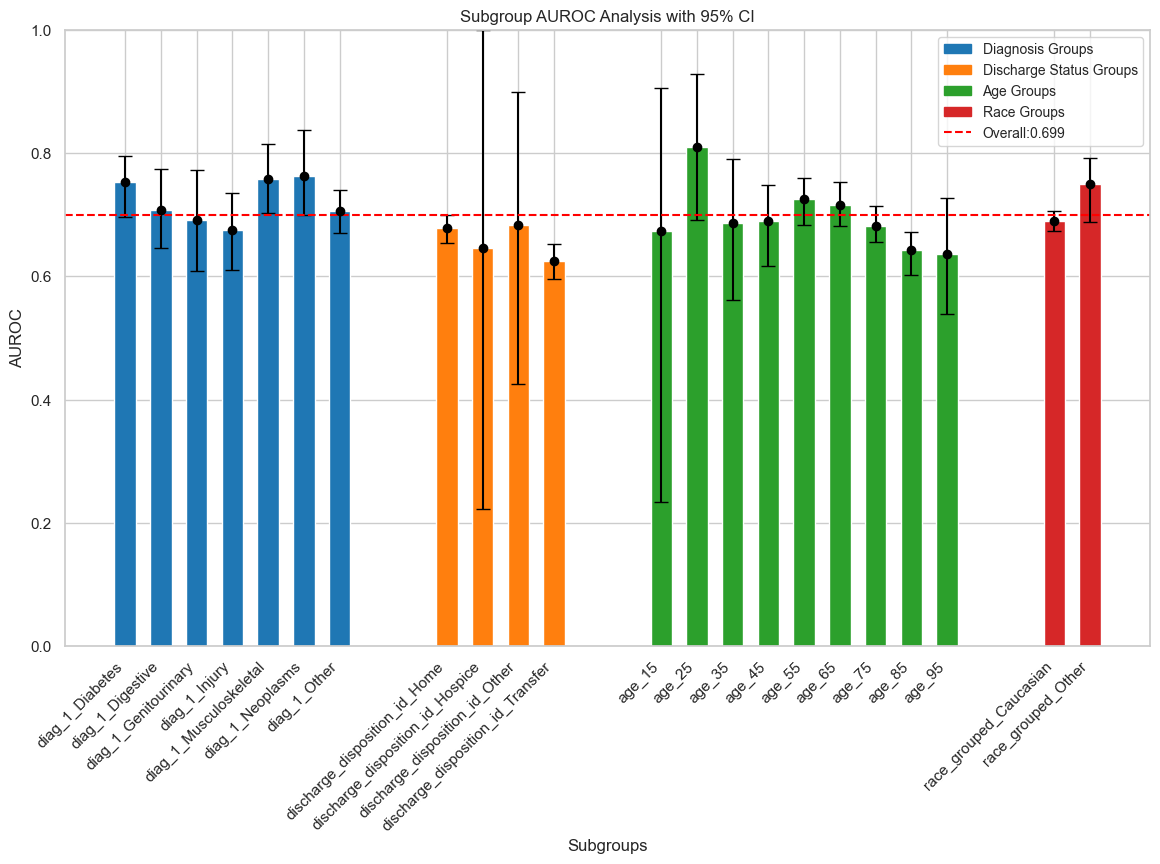

,Group,Subgroup,Metric,95% CI Lower,95% CI Upper,Sample Size
0,Diagnosis Groups,diag_1_Diabetes,0.753,0.697,0.795,1149
1,Diagnosis Groups,diag_1_Digestive,0.708,0.646,0.774,1392
2,Diagnosis Groups,diag_1_Genitourinary,0.691,0.609,0.772,689
3,Diagnosis Groups,diag_1_Injury,0.676,0.610,0.736,990
4,Diagnosis Groups,diag_1_Musculoskeletal,0.758,0.703,0.815,779
5,Diagnosis Groups,diag_1_Neoplasms,0.763,0.699,0.837,559
6,Diagnosis Groups,diag_1_Other,0.706,0.671,0.740,2541
7,Discharge Status Groups,discharge_disposition_id_Home,0.678,0.654,0.699,10334
8,Discharge Status Groups,discharge_disposition_id_Hospice,0.646,0.223,1.000,110
9,Discharge Status Groups,discharge_disposition_id_Other,0.684,0.426,0.900,64


In [30]:
subgroup_analysis_with_plot(trainer_wo_cluster, group_sets, metric='auroc', n_bootstrap=100, confidence=0.95)

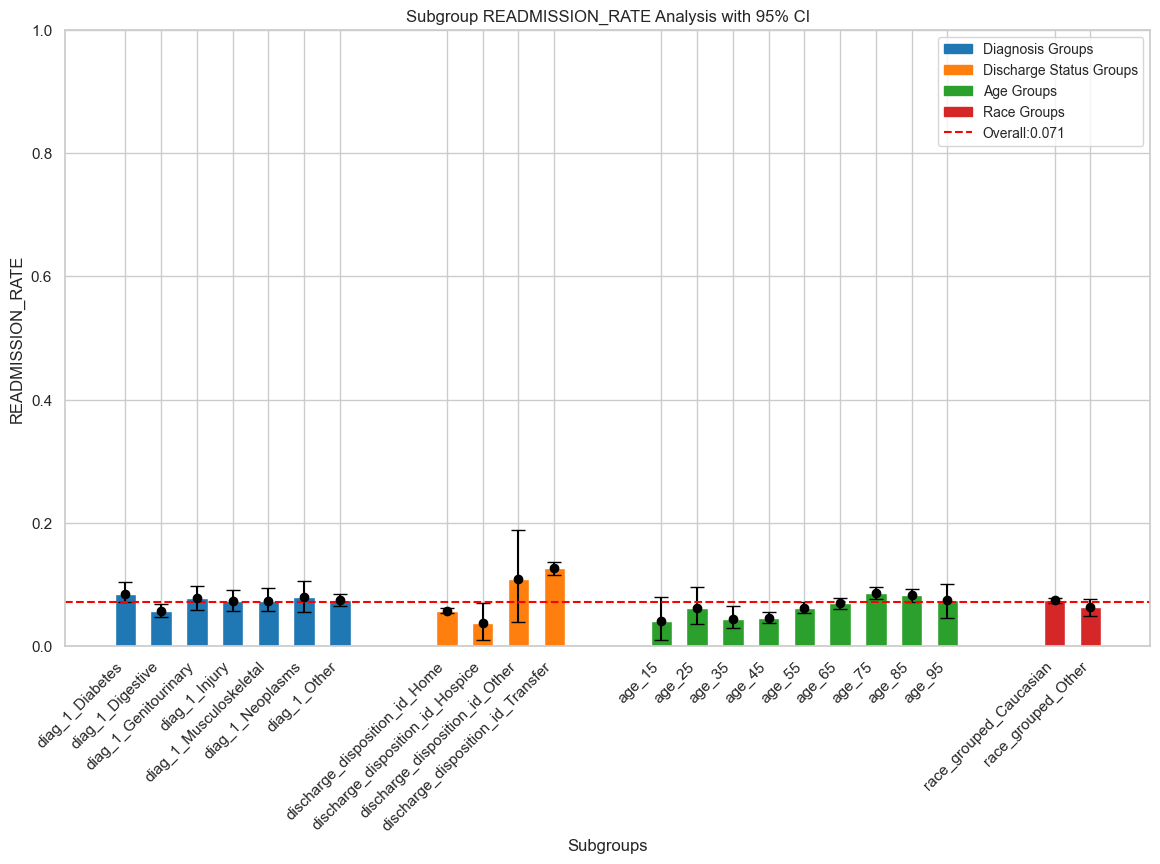

,Group,Subgroup,Metric,95% CI Lower,95% CI Upper,Sample Size
0,Diagnosis Groups,diag_1_Diabetes,0.084,0.071,0.103,1149
1,Diagnosis Groups,diag_1_Digestive,0.057,0.047,0.068,1392
2,Diagnosis Groups,diag_1_Genitourinary,0.078,0.058,0.098,689
3,Diagnosis Groups,diag_1_Injury,0.073,0.057,0.090,990
4,Diagnosis Groups,diag_1_Musculoskeletal,0.073,0.057,0.094,779
5,Diagnosis Groups,diag_1_Neoplasms,0.079,0.055,0.106,559
6,Diagnosis Groups,diag_1_Other,0.074,0.065,0.084,2541
7,Discharge Status Groups,discharge_disposition_id_Home,0.057,0.053,0.061,10334
8,Discharge Status Groups,discharge_disposition_id_Hospice,0.038,0.009,0.069,110
9,Discharge Status Groups,discharge_disposition_id_Other,0.109,0.039,0.188,64


In [31]:
subgroup_analysis_with_plot(trainer_wo_cluster, group_sets, metric='readmission_rate', n_bootstrap=100, confidence=0.95)